<a href="https://colab.research.google.com/github/farhananwari07/TugbesTKC_145-157/blob/main/Tugas6_AplikasiCBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [3]:
%cd /content/drive/MyDrive/TKC

/content/drive/MyDrive/TKC


In [4]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

  0%|          | 0/169168619 [00:00<?, ?it/s]

In [5]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [6]:
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['household_electrical_devices', 'vehicles_1', 'people', 'medium_mammals', 'small_mammals', 'fish', 'aquatic_mammals', 'large_man-made_outdoor_things', 'large_carnivores', 'food_containers', 'reptiles', 'large_omnivores_and_herbivores', 'large_natural_outdoor_scenes', 'household_furniture', 'vehicles_2', 'insects', 'flowers', 'trees', 'fruit_and_vegetables', 'non-insect_invertebrates']


In [17]:
x=len(os.listdir('./data/cifar100/train'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/train/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/train/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TRAINING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 500
TRAINING SET CONTAINS 50000 IMAGES


In [18]:
x=len(os.listdir('./data/cifar100/test'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/test/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/test/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TESTING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 100
TESTING SET CONTAINS 10000 IMAGES


In [19]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [20]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #channel are at the last in matplotlib where it was at front in tensors

Label:  aquatic_mammals (0)


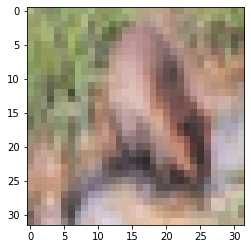

In [21]:
show_example(*dataset[6])

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [9]:
# Data transforms (normalization & data augmentation)
stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [10]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [11]:
batch_size = 250

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


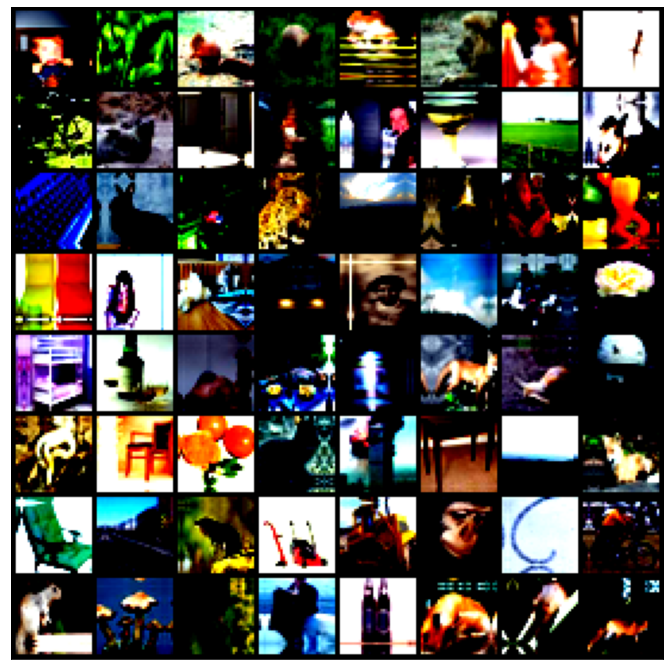

In [14]:
show_batch(train_dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)